In [1]:
# keras supplied image generator
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2DTranspose, Conv2D, UpSampling2D, Reshape, Flatten, MaxPooling2D
from keras.optimizers import RMSprop
from IPython.display import Image, display
from itertools import repeat
import PIL
from datetime import datetime

import numpy as np

#the size for both the real and the fake data
partial_batch_size = 64
scale_up = 4

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

read_data_gen = datagen.flow_from_directory(os.getcwd()+'/training/', target_size=(64,64),batch_size=partial_batch_size)

def output_to_image(array):
    array = array*127.5+127.5
    i = array_to_img(array).resize((64*scale_up,64*scale_up), PIL.Image.ANTIALIAS)
    return i


Using TensorFlow backend.


Found 729 images belonging to 3 classes.


Generator is based off of `UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS` available [here](https://arxiv.org/abs/1511.06434)

In [2]:
def get_generator():
    m = Sequential()
    m.add(Dense((4*4*1024), input_shape=(100,), activation = 'relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(Reshape((4,4,1024)))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(512,8, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(256,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(128,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(64,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Dropout(0.5))
    m.add(Conv2DTranspose(3,5, activation = 'sigmoid', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    return m

generator_model = get_generator()
generator_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
generator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         33554944  
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 512)       0         
__________

This network takes 100 random numbers and generates an eye from it (once it's been trained). 

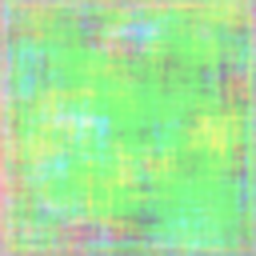

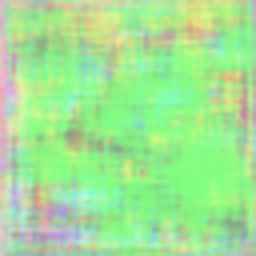

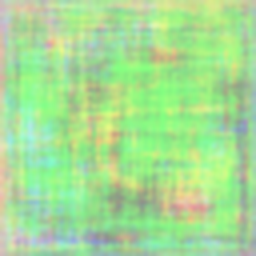

In [3]:
sample_in = np.random.uniform(-1, 1, (3,100))

sample_out = generator_model.predict(sample_in)

for a in sample_out:
    display(output_to_image(a))

For comparison, here are some real images:

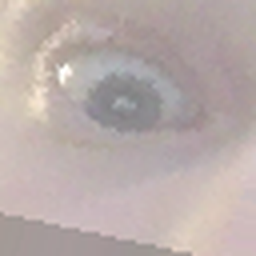

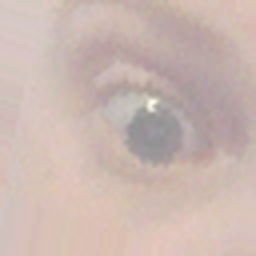

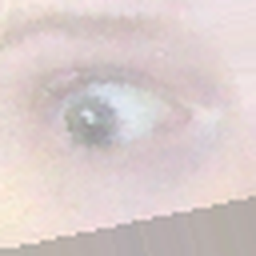

In [4]:

for eye in next(read_data_gen)[0][1:4]:
    display(output_to_image(eye))

For simplicity, we'll use a simple classifier from [Keras's blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [5]:
def get_descriminator():
    m = Sequential()
    m.add(Conv2D(32,3, input_shape=(64,64,3,), activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Dropout(0.5))
    m.add(Conv2D(32,3, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Dropout(0.5))
    m.add(Conv2D(64,3, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(MaxPooling2D(2,2))
    m.add(Dropout(0.5))
    m.add(Flatten())
    m.add(Dense(1, activation = 'sigmoid'))
    return m

descriminator = get_descriminator()
descriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
__________

Finally we'll combine and compile the two models:

In [6]:
def compile(descriminator, generator):
    combined = Sequential()
    combined.add(generator)
    combined.add(descriminator)
    combined.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001))
    
    descriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001))
    generator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001))
    return combined, descriminator, generator

combined, descriminator, generator = compile(get_descriminator(), get_generator())
    
# not as exciting as it could be...
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 64, 3)         39515779  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 32737     
Total params: 39,548,516.0
Trainable params: 39,548,516.0
Non-trainable params: 0.0
_________________________________________________________________


Now all we have to do is train it.

Epoch 1/50
1330/1330 [==============================] - 4s - loss: 0.1420     
Epoch 2/50
1330/1330 [==============================] - 4s - loss: 0.1128     
Epoch 3/50
1330/1330 [==============================] - 4s - loss: 0.0016     
Epoch 4/50
1330/1330 [==============================] - 4s - loss: 5.5292e-04     
Epoch 5/50
1330/1330 [==============================] - 4s - loss: 0.0817     
Epoch 6/50
1330/1330 [==============================] - 4s - loss: 6.4312e-05     
Epoch 7/50
1330/1330 [==============================] - 4s - loss: 4.6219e-05     
Epoch 8/50
1330/1330 [==============================] - 4s - loss: 4.1524e-05     
Epoch 9/50
1330/1330 [==============================] - 4s - loss: 0.1300     
Epoch 10/50
1330/1330 [==============================] - 4s - loss: 1.5766e-05     
Epoch 11/50
1330/1330 [==============================] - 4s - loss: 2.9349e-06     
Epoch 12/50
1330/1330 [==============================] - 4s - loss: 1.2893e-06     
Epoch 13/50
1330/1330

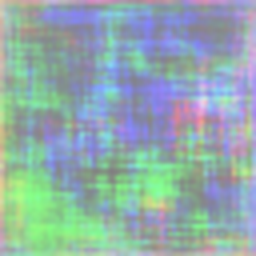

2017-07-20 23:33:21.282287: Step: 0, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:33:49.102369: Step: 1, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:34:16.844592: Step: 2, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:34:44.361965: Step: 3, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:35:12.046755: Step: 4, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:35:39.699378: Step: 5, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:36:07.567886: Step: 6, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:36:35.880999: Step: 7, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:37:04.370965: Step: 8, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:37:32.098654: Step: 9, Descriminator: 0.000000, Combined: 16.118095


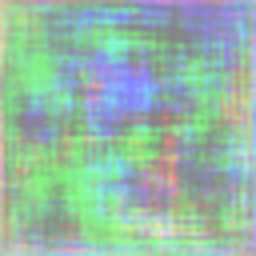

2017-07-20 23:38:00.258391: Step: 10, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:38:24.455756: Step: 11, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:38:52.248669: Step: 12, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:39:20.198627: Step: 13, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:39:47.697945: Step: 14, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:40:15.476584: Step: 15, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:40:43.135871: Step: 16, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:41:10.881857: Step: 17, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:41:38.528980: Step: 18, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:42:06.858989: Step: 19, Descriminator: 0.000000, Combined: 16.118095


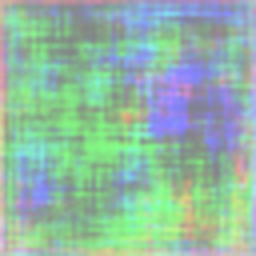

2017-07-20 23:42:34.468993: Step: 20, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:43:02.203329: Step: 21, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:43:30.319323: Step: 22, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:43:54.542258: Step: 23, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:44:22.192596: Step: 24, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:44:49.834963: Step: 25, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:45:17.325831: Step: 26, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:45:44.828651: Step: 27, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:46:12.416004: Step: 28, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:46:40.038592: Step: 29, Descriminator: 0.000000, Combined: 16.118095


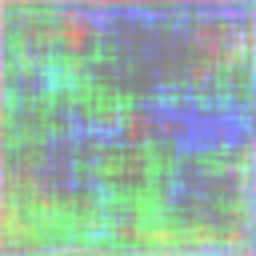

2017-07-20 23:47:08.486240: Step: 30, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:47:35.923805: Step: 31, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:48:03.849430: Step: 32, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:48:31.738871: Step: 33, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:48:59.392580: Step: 34, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:49:23.382429: Step: 35, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:49:50.785152: Step: 36, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:50:18.406430: Step: 37, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:50:45.933786: Step: 38, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:51:13.605627: Step: 39, Descriminator: 0.000000, Combined: 16.118095


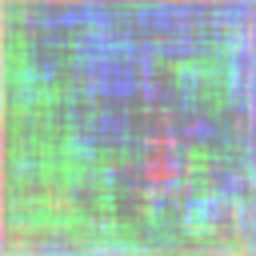

2017-07-20 23:51:41.355444: Step: 40, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:52:09.941035: Step: 41, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:52:37.385599: Step: 42, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:53:04.833664: Step: 43, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:53:32.828598: Step: 44, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:54:00.201910: Step: 45, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:54:27.506854: Step: 46, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:54:51.322457: Step: 47, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:55:19.104078: Step: 48, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:55:46.550111: Step: 49, Descriminator: 0.000000, Combined: 16.118095


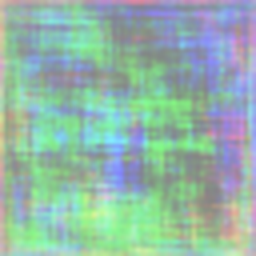

2017-07-20 23:56:14.119610: Step: 50, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:56:41.480269: Step: 51, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:57:09.435256: Step: 52, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:57:36.783713: Step: 53, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:58:04.443742: Step: 54, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:58:31.748970: Step: 55, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:59:00.066502: Step: 56, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:59:28.199177: Step: 57, Descriminator: 0.000000, Combined: 16.118095
2017-07-20 23:59:55.508143: Step: 58, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:00:20.277329: Step: 59, Descriminator: 0.000000, Combined: 16.118095


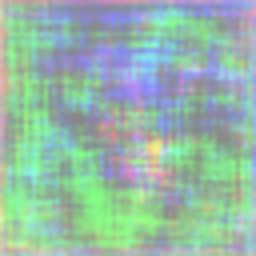

2017-07-21 00:00:47.646929: Step: 60, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:01:15.057554: Step: 61, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:01:42.745666: Step: 62, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:02:10.869952: Step: 63, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:02:38.533823: Step: 64, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:03:06.479469: Step: 65, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:03:34.110513: Step: 66, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:04:01.554791: Step: 67, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:04:29.238549: Step: 68, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:04:56.755550: Step: 69, Descriminator: 0.000000, Combined: 16.118095


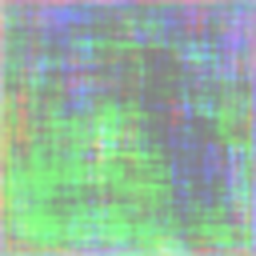

2017-07-21 00:05:24.303357: Step: 70, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:05:48.077196: Step: 71, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:06:15.643145: Step: 72, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:06:43.562215: Step: 73, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:07:11.390724: Step: 74, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:07:38.700892: Step: 75, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:08:06.086954: Step: 76, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:08:33.572973: Step: 77, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:09:01.094776: Step: 78, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:09:28.660618: Step: 79, Descriminator: 0.000000, Combined: 16.118095


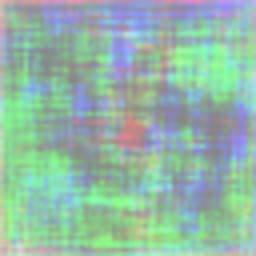

2017-07-21 00:09:56.180257: Step: 80, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:10:23.644738: Step: 81, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:10:50.963112: Step: 82, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:11:15.679310: Step: 83, Descriminator: 0.000000, Combined: 16.118095
2017-07-21 00:11:43.069309: Step: 84, Descriminator: 0.000000, Combined: 16.118095


KeyboardInterrupt: 

In [7]:
def fit(steps = 10000):
    
    def gen_data():
        real = next(read_data_gen)[0]
        
        # if the number of real images isn't evenly divided by the target batch size, this will be different at the end
        actual_batch_size = len(real)
        
        fake_in = np.random.uniform(-1, 1, (actual_batch_size,100))
        fake = generator.predict(fake_in)
        
        x = np.concatenate((real,fake))
        y = np.ones([actual_batch_size*2,1])
        y[actual_batch_size:,:] = 0
        
        return x, y


    # x,y = gen_data()
    # descriminator.fit(x,y, epochs = 50, verbose = True)
    
    for step in range(steps):
        x, y = gen_data()
        
        d_err = descriminator.train_on_batch(x,y)
        
        fake_in = np.random.uniform(-1, 1, (partial_batch_size,100))
        y = np.ones([partial_batch_size,1])
        descriminator.trainable = False
        c_err = combined.train_on_batch(fake_in, y)
        descriminator.trainable = True
        
        sample = generator.predict(fake_in)[0]

        if step % 10 == 0:
            display(output_to_image(sample))
        print("%s: Step: %d, Descriminator: %f, Combined: %f"%(str(datetime.now()), step, d_err, c_err))
        
        
fit()
        